In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import math
from bjontegaard_metric import *
from sklearn.metrics import r2_score

In [14]:
def bpm(t, c0, c2, c3):
    return c0-c2*np.exp(-c3*t)
# def bpm(t, c0, c1, c2, c3):
#     return c0+c1*t-c2*np.exp(-c3*t)

In [15]:
def modeling(camera_positions, scenes, QPs, synthesizers, numGroups, pose_traces, numFrame):
    '''
    Compare different QPs
    synthesizer = 'AdditiveSynthesizer'
    numGroup = 1
    camera positions = '6x6'
    all pose traces
    all scenes
    '''
    doplot = False

    scenes = np.array(['LightroomInteriorDayLight', 'office', 'RealisticRendering', 'XoioBerlinFlat'])
    
    df = pd.DataFrame()
    df = pd.read_csv(f'./results/0_to_50_all_nG1.csv')

    # for scene in ['LightroomInteriorDayLight']:
    for scene in scenes:
        print(scene)
        # Baseline data
        df_tmp = df
        # don't discuss sphere_6x6 camera placement 
        df_tmp = df_tmp.loc[(df_tmp["camera_position"] != 'sphere_6x6')]
        # set filter
        df_tmp = df_tmp.loc[(df_tmp['synthesizer'] == 'AdditiveSynthesizer')]
        df_tmp = df_tmp.loc[(df_tmp['camera_position'] == '6x6')]
        df_tmp = df_tmp.loc[(df_tmp['scene'] == scene)]

        df_tmp['Mbitrate'] = df_tmp['bitrate'].apply(lambda x: x*(0.000001))
        # change scene name
        df_tmp['scene'] = df_tmp['scene'].replace(['ArchVizInterior', 'LightroomInteriorDayLight', 'office', 'RealisticRendering', 'XoioBerlinFlat'], ['Arch', 'Light', 'Office', 'Real', 'Xoio'])
        
        # # Do RD-curve
        # ax = sns.lineplot(x=f'Mbitrate', y=f'vmaf_mean', data=df_tmp, ci=None)
        # ax.set(xlabel="Bitrate (Mbps)", ylabel=f"Quality in VMAF")
        # plt.ylim((0,100))
        # if doplot:
        #     plt.savefig(f'./img/QP_average/RDcurve_vmaf_bitrate_scene_in_AdditiveSynthesizer.eps', dpi=300, pad_inches=0, bbox_inches='tight')
        #     plt.savefig(f'./img/QP_average/RDcurve_vmaf_bitrate_scene_in_AdditiveSynthesizer.png', dpi=300, pad_inches=0, bbox_inches='tight')
        # plt.show()
        
        # guess = [70,0.01,100,0.03]
        # guess = [63,0.0001,37,1]
        guess = [63,37,1]

        

        vmaf_data = []
        bitrate_data = []
        for QP in QPs:
            vmaf_data.append(df_tmp.loc[df_tmp['QP'] == QP]['vmaf_mean'].mean())
            bitrate_data.append(df_tmp.loc[df_tmp['QP'] == QP]['Mbitrate'].mean())

        df_new = pd.DataFrame()
        df_new['Mbitrate'] = np.array(bitrate_data)
        df_new['vmaf_mean'] = np.array(vmaf_data)

        # df_new = df_tmp
        

        n = len(df_new['Mbitrate'])
        print(df_new['Mbitrate'].values[0])
        y = np.empty(n)
        for i in range(n):
            # y[i] = bpm(df_new['Mbitrate'].values[i], guess[0], guess[1], guess[2])
            y[i] = bpm(df_new['Mbitrate'][i], guess[0], guess[1], guess[2])
            # y[i] = bpm(df_new['Mbitrate'][i], guess[0], guess[1], guess[2], guess[3])

        plt.plot(df_new['Mbitrate'], df_new['vmaf_mean'])
        plt.plot(df_new['Mbitrate'], y, 'r.')
        plt.show()


        x = df_new['Mbitrate'].values
        y = df_new['vmaf_mean'].values
        c, cov = curve_fit(bpm,x,y,guess)
        print(c) # the coefficient

        y_reg = []
        for i in df_new['Mbitrate']:
            y_reg.append(bpm(i, c[0], c[1], c[2]))
            # y_reg.append(bpm(i, c[0], c[1], c[2], c[3]))

        plt.plot(df_new['Mbitrate'], df_new['vmaf_mean'])
        plt.plot(df_new['Mbitrate'], y_reg, 'r.')
        plt.show()


        print('R^2:', r2_score(df_new['vmaf_mean'].values, y_reg))

        x_min = df_new['Mbitrate'].min()
        x_max = df_new['Mbitrate'].max()
        x_reg = np.linspace(x_min, x_max, num=100)
        y_reg = np.empty(len(x_reg))
        for i in range(len(x_reg)):
            y_reg[i] = bpm(x_reg[i], c[0], c[1], c[2])
            # y_reg[i] = bpm(x_reg[i], c[0], c[1], c[2], c[3])

        plt.plot(df_new['Mbitrate'], df_new['vmaf_mean'])
        plt.plot(x_reg, y_reg)
        plt.show()

        # Baseline data
        df_tmp = df
        # don't discuss sphere_6x6 camera placement 
        df_tmp = df_tmp.loc[(df_tmp["camera_position"] != 'sphere_6x6')]
        # set filter
        df_tmp = df_tmp.loc[(df_tmp['synthesizer'] == 'AdditiveSynthesizer')]
        df_tmp = df_tmp.loc[(df_tmp['camera_position'] == '6x6')]
        df_tmp = df_tmp.loc[(df_tmp['scene'] == scene)]

        df_tmp['Mbitrate'] = df_tmp['bitrate'].apply(lambda x: x*(0.000001))
        # change scene name
        df_tmp['scene'] = df_tmp['scene'].replace(['ArchVizInterior', 'LightroomInteriorDayLight', 'office', 'RealisticRendering', 'XoioBerlinFlat'], ['Arch', 'Light', 'Office', 'Real', 'Xoio'])
        
        y_reg = []
        for i in df_tmp['Mbitrate']:
            y_reg.append(bpm(i, c[0], c[1], c[2]))

        plt.plot(df_tmp['Mbitrate'], df_tmp['vmaf_mean'])
        plt.plot(df_tmp['Mbitrate'], y_reg, 'r.')
        plt.show()

        print('R^2:', r2_score(df_tmp['vmaf_mean'].values, y_reg))
    

In [16]:
def check():
    doplot = False

    scene = 'RealisticRendering'
    
    df = pd.DataFrame()
    df = pd.read_csv(f'./results/user_study_modeling_data.csv')
    QPs = [20, 36, 44, 48, 50]
    c = [67.86744704, 60.1874818, 1.65287379]
    
    # Baseline data
    df_tmp = df
    # don't discuss sphere_6x6 camera placement 
    df_tmp = df_tmp.loc[(df_tmp["camera_position"] != 'sphere_6x6')]
    # set filter
    df_tmp = df_tmp.loc[(df_tmp['synthesizer'] == 'AdditiveSynthesizer')]
    df_tmp = df_tmp.loc[(df_tmp['camera_position'] == '6x6')]
    df_tmp = df_tmp.loc[(df_tmp['scene'] == scene)]

    df_tmp['Mbitrate'] = df_tmp['bitrate'].apply(lambda x: x*(0.000001))
    # change scene name
    df_tmp['scene'] = df_tmp['scene'].replace(['ArchVizInterior', 'LightroomInteriorDayLight', 'office', 'RealisticRendering', 'XoioBerlinFlat'], ['Arch', 'Light', 'Office', 'Real', 'Xoio'])

    y_reg = []
    for i in df_tmp['Mbitrate']:
        y_reg.append(bpm(i, c[0], c[1], c[2]))
        # y_reg.append(bpm(i, c[0], c[1], c[2], c[3]))

    plt.plot(df_tmp['Mbitrate'], df_tmp['vmaf_mean'])
    plt.plot(df_tmp['Mbitrate'], y_reg, 'r.')
    plt.show()

    print('R^2:', r2_score(df_tmp['vmaf_mean'].values, y_reg))
        

In [17]:
def main():
    # setup paras
    # camera_positions = np.array(["6x6", "9x4", "12x3", "18x2"])
    # scenes = np.array(['ArchVizInterior', 'LightroomInteriorDayLight', 'office', 'RealisticRendering', 'XoioBerlinFlat'])
    # QPs = np.array([20, 36, 44, 48, 50])
    # synthesizers = np.array(["AdditiveSynthesizer", "ViewWeightingSynthesizer"])
    # numGroups = np.array([1])
    # pose_traces = np.array([f'pose{i}' for i in range(10)])
    # numFrame = 1

    # 1
    camera_positions = np.array(["6x6", "9x4", "12x3", "18x2"])
    scenes = np.array(['ArchVizInterior', 'LightroomInteriorDayLight', 'office', 'RealisticRendering', 'XoioBerlinFlat'])
    QPs = np.array([0, 8, 16, 20, 28, 36, 44, 48, 50])
    synthesizers = np.array(["AdditiveSynthesizer", "ViewWeightingSynthesizer"])
    numGroups = np.array([1])
    pose_traces = np.array([f'pose{i}' for i in range(10)])
    numFrame = 1

    
    modeling(camera_positions, scenes, QPs, synthesizers, numGroups, pose_traces, numFrame)
    check()

LightroomInteriorDayLight
45.03692


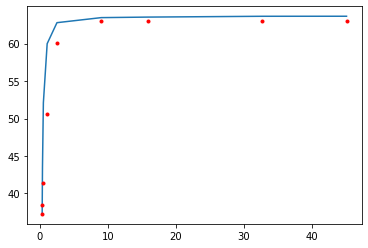

[ 63.07800345 128.19633855   4.49344238]


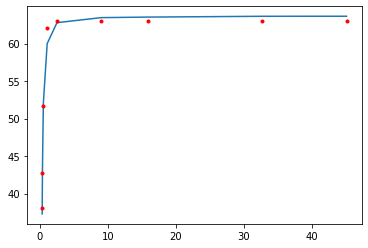

R^2: 0.9913191680174145


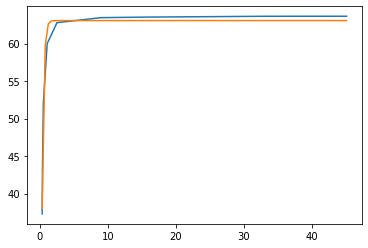

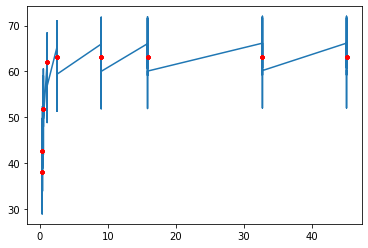

R^2: 0.7166167545528792
office
44.24663199999999


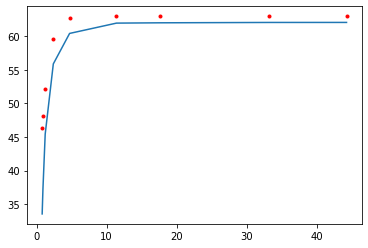

[61.74560628 65.19913321  1.07390362]


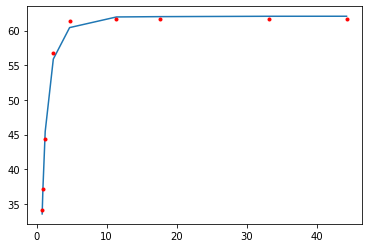

R^2: 0.9969335983533916


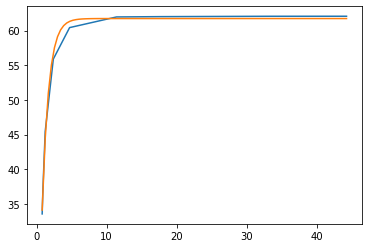

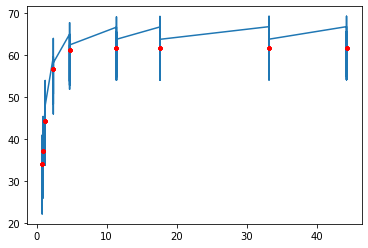

R^2: 0.7921004479238245
RealisticRendering
44.862592


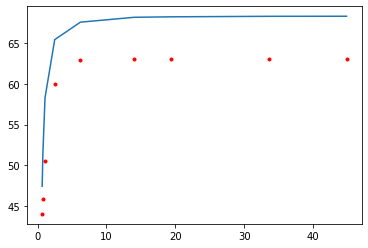

[67.86744704 60.1874818   1.65287379]


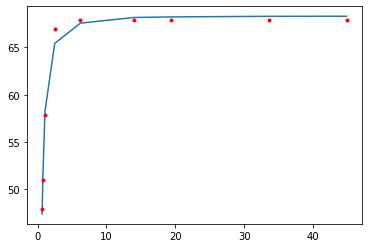

R^2: 0.9935621045878006


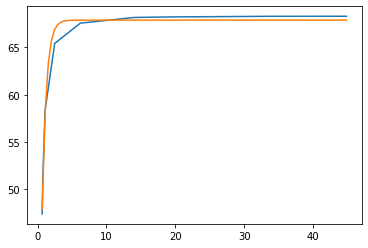

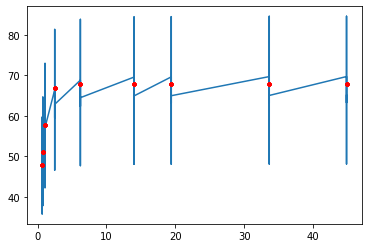

R^2: 0.43439730862766635
XoioBerlinFlat
33.21348


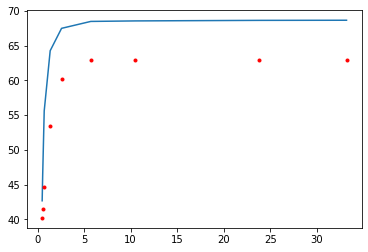

[68.19476012 95.59187851  2.75037253]


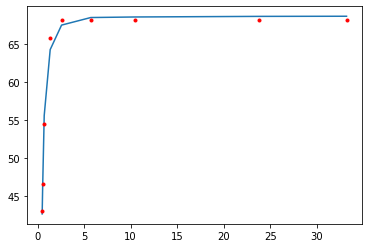

R^2: 0.9942007117670703


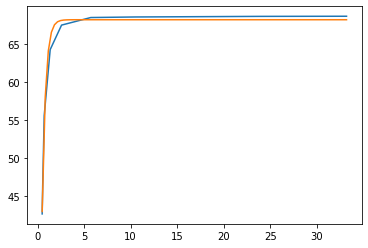

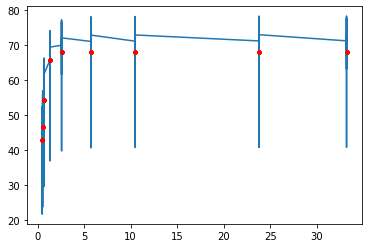

R^2: 0.47347661425659315


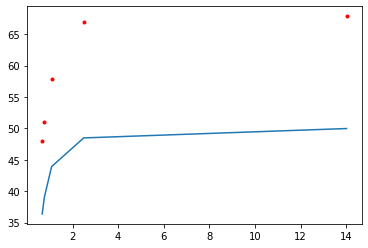

R^2: -7.214517010018092


In [18]:
if __name__ == '__main__':
    main()